In [51]:
""" Import of modules """
import numpy.random as np
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
from tqdm import tqdm_notebook as tqdm
sns.set()

""" Initialization """
Npop = 10000 #Population size
parr = numpy.exp(numpy.arange(-24, -14)) #Mutation rate
narr = numpy.exp(numpy.arange(14, 25)) #Cell number
# garr = numpy.array([0.03125, 0.0625, 0.125, 0.25, 0.5])
# rep = 100

ndiv = 10 #Number of cell divisions per year
age = 90 #Lifespan
time = ndiv*age #Duration of the simulation


threshold = 5 #Mutation threshold for cancer
n = narr[5] #Carrying capacity
p = parr[-1] #Mutation rate


wts=numpy.array([0.013818048555027355, 0.0553159434123515, 0.07253241028642805, 0.07303103455912367, 0.07216711636515384, 0.06647847243710951, 0.06452984736662379, 0.07104508339877749, 0.08076197744193335, 0.08185169462960405, 0.07211714069611326, 0.06271758577923968, 0.048454493422914295, 0.038794489715138394, 0.034263609991378986, 0.03177168658747205, 0.026997999757072733, 0.017842803104216928, 0.01550856249432107]) #Weights from the US 2000 standard population
n_class = len(wts)

cancer_count = numpy.zeros(age) #Age-wise incidence of cancer
num_surv = numpy.zeros(age) #Number of survivors in each age/generation
cancer_fract = numpy.zeros(age) #Normalized incidence of cancer
cumul_count = numpy.zeros(age) #Cumulative count of cancer
crude_rate = numpy.zeros(age) #Calculated age-wise incidence per 100000

# g_inc = 0.5
g = numpy.linspace(0.75, 3, threshold+1) #Growth rate progression
d = g[0]/2 #Constant death rate
pop_mut = numpy.zeros(time, dtype=int) #Number of mutations

nzeros = numpy.zeros
RAND = np.random_sample
# dataframe = pd.DataFrame
persistence = nzeros(Npop*(threshold-1)).reshape(Npop, (threshold-1))

for j in tqdm(range(Npop), desc='Npop', leave=False):
    t=0 #Index to track time
    n_mut = nzeros(time, dtype=int) #Number of mutations
    m = numpy.zeros((threshold+1)*time).reshape((threshold+1), time)
    m[0, 0] = n
    p_mut=1-((1-p)**m[0, 0]) #Initial probabiltiy of first mutation arising in the population
#     df_mut = dataframe(n_mut).T

    for t in range(1, time):

        n_mut[t] = n_mut[t-1]
        m[:, t] = m[:, t-1]
        p_mut = 1-(1-p)**m[n_mut[t], t]

        if p_mut > RAND(): #New mutant population
            n_mut[t] += 1
            m[n_mut[t], t] = 1.0
            p_mut = 1-((1-p)**m[n_mut[t], t])
            m[n_mut[t]-1, t] -= 1.0

        elif n_mut[t] > 0: #Growth of existing mutant or normal population, as the case may be
            m[:, t] += ((m[:, t]*g*(n-m[:, t].sum())/n) - m[:, t]*d)
            p_mut = 1-(1-p)**m[n_mut[t], t]
        
        pop_mut += n_mut
        
        if n_mut[t] == threshold:
            cancer_count[int(t/ndiv)] += 1
            persistence[j] = numpy.array([len(n_mut[n_mut==a]) for a in range(1,threshold)])
#             df_mut = df_mut.append(pd.DataFrame(n_mut).T)
            break

""" Calculations """
cumul_count = cancer_count.cumsum()

num_surv = numpy.array([Npop]*age, dtype=float)
num_surv[1:] -= cumul_count[:-1]

cancer_fract = cancer_count/(cancer_count+num_surv)
crude_rate = cancer_fract*100000

/home/iiser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


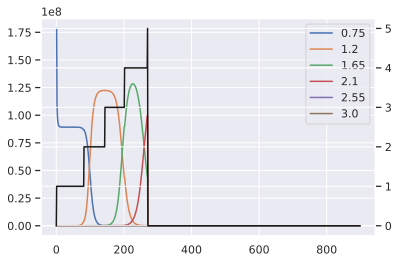

In [52]:
fig, ax = plt.subplots()
for i,l in zip(m, g.round(decimals=2)):
    ax.plot(i, label=l)
plt.legend()

mx = ax.twinx()
mx.plot(n_mut, 'k')

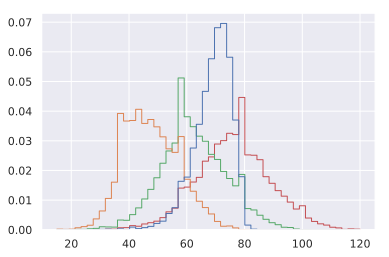

In [55]:
h = plt.hist([persistence[:, a] for a in range(threshold-1)], bins=50, histtype='step', density=True)

- pmean0, pstd0: narr[2]
- pmean1, pstd1: narr[5]
- pmean2, pstd2: narr[8]
- pmean3, pstd3: narr[-1]
- pmean4, pstd4: parr[2]
- pmean5, pstd5: parr[8]
- pmean6, pstd6: parr[-1]

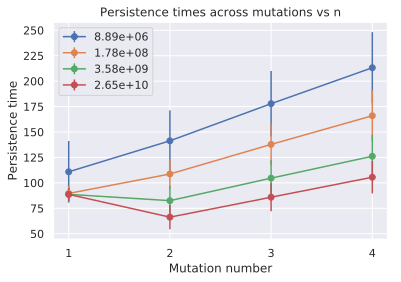

In [56]:
pos = numpy.array([1, 2, 3, 4])
# width = 0.5
for pmu, ps, l in zip([pmean0, pmean1, pmean2, pmean3], [pstd0, pstd1, pstd2, pstd3], [narr[2], narr[5], narr[8], narr[-1]]):
    p = plt.errorbar(pos, pmu, yerr=ps, fmt='o-', label=numpy.format_float_scientific(l, precision=2))
plt.xticks(pos, ('1', '2', '3', '4'))
plt.ylabel('Persistence time')
plt.xlabel('Mutation number')
plt.title('Persistence times across mutations vs n')
plt.legend()

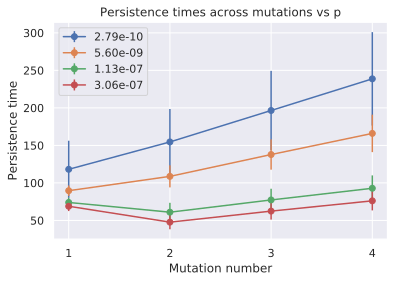

In [54]:
for pmu, ps, l in zip([pmean4, pmean1, pmean5, pmean6], [pstd4, pstd1, pstd5, pstd6], [parr[2], parr[5], parr[8], parr[-1]]):
    p = plt.errorbar(pos, pmu, yerr=ps, fmt='o-', label=numpy.format_float_scientific(l, precision=2))
plt.xticks(pos, ('1', '2', '3', '4'))
plt.ylabel('Persistence time')
plt.xlabel('Mutation number')
plt.title('Persistence times across mutations vs p')
plt.legend()

## It has taken the largest values of `n` and `p`, along with `numpy.linspace(0.1, 4, threhsold+1)` for this to work; this needs to be unpacked a little bit.
- This is interesting-`numpy.linspace(0.75, 3, threshold+1)` seems to work across the range of `n` and `p`; I see here that the rate of mutation accumulation can be controlled using the growth rate progression and the death rate. For a non-mutant growth rate of 0.1, progression is slow as clonal expansion of the subsequent mutation takes longer. This means that for a relatively smaller non-mutant growth rate, populations spend longer time in intermediate mutants, with limited clonal expansions. On the other hand, as has been noted in `cell-competiton-model`, the progression of growth rates cannot be very steep as it hinders the progression of late-stage mutants. The ideal balance is gotten with a non-mutant growth rate above 0.5, and a death rate of about half that value. This gives enough step size for clonal expansion while also allowing for faster replacement due to the high death rate for the non-mutant.
- A couple of problems-
    - The high death rate might be physiologically unrealistic, which would inform inferences/predictions. But again, as noted in `cell-competition-model`, without this high death rate, mutation accumulation is purely limited by time, and therefore does not progress sufficiently within physiologically realistic lifespans. I say limited by time, because it is not a matter of mutation rate, but that of clonal growth. This is another interesting feature that comes up repeatedly in this model; mutation accumulation and clonal expansion seem to progress on different timescales frequently.
    - The stable oscillations with large/steep growth rate values/progression remains unresolved.